# Problem 10.5

$$
P=P(Y|\theta,\beta,\gamma)P(\theta,\beta|\gamma)P(\gamma)
$$

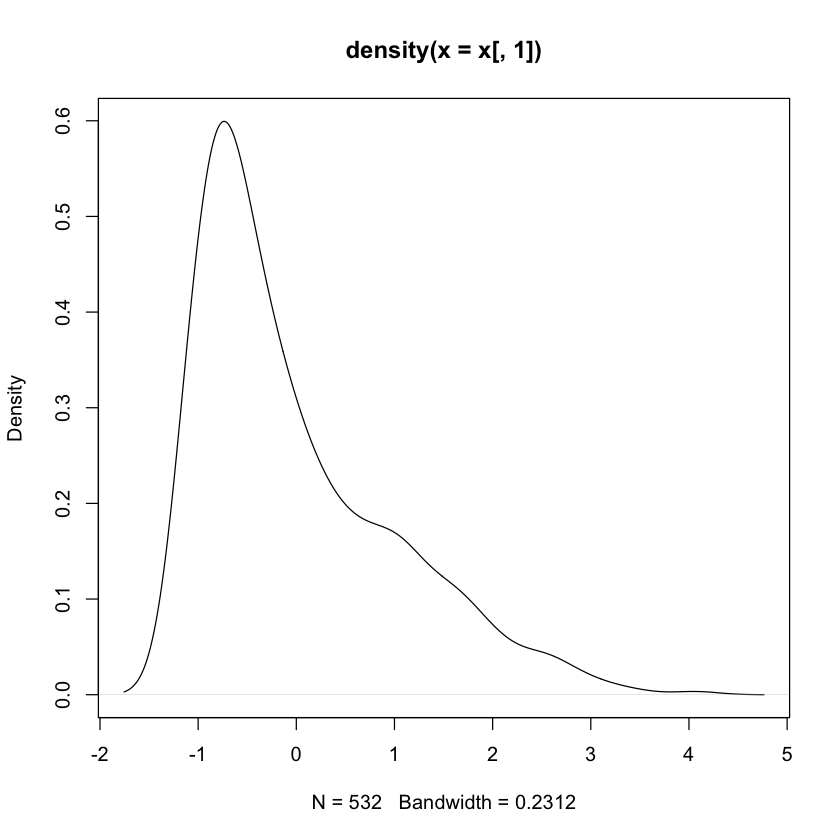

In [5]:
library(MCMCpack)
library(mvtnorm)
df<-read.table('azdiabetes.dat')
y<-df[-1,8]
df<-df[-1,c(1,3,5,6,7)]
n<-nrow(df)
df[,]<-lapply(df[,],as.numeric)
y<-as.numeric(y=='Yes')
x<-df-t(matrix(rep(colMeans(df),n),nrow=5,ncol=n))#minus mean
x<-x/(t(matrix(rep(sqrt(colMeans(x^2)*n/(n-1)),n),nrow=5,ncol=n)))#divide by ssd
par(bg='white')
plot(density(x[,1]))
x<-as.matrix(x)
y<-as.matrix(y)
gamma<- rbinom(5,1,0.5)
beta<-rnorm(6,0,c(4,2,2,2,2,2))

In [6]:
mle<-glm(y~ 1+x, family=binomial)
beta<-coef(mle)
beta.var<-summary(mle)$cov.unscaled
beta.var

,(Intercept),xV1,xV3,xV5,xV6,xV7
(Intercept),1.174672e-02,-0.0006815038,2.526404e-06,-0.0026093192,-0.0009622830,-0.0016211391
xV1,-6.815038e-04,0.0165499465,1.923670e-04,0.0014404209,0.0009032335,-0.0101566782
xV3,2.526404e-06,0.0001923670,1.332025e-02,-0.0039435271,0.0004993161,-0.0045273243
xV5,-2.609319e-03,0.0014404209,-3.943527e-03,0.0143639607,0.0001360168,0.0019161173
xV6,-9.622830e-04,0.0009032335,4.993161e-04,0.0001360168,0.0115819783,-0.0003218046
xV7,-1.621139e-03,-0.0101566782,-4.527324e-03,0.0019161173,-0.0003218046,0.0183054196


In [7]:
  
ilogit<-function(theta){
  out<-exp(theta)/(1+exp(theta))
  return(out)
}
# rit_gamma<-function(gamma){
#   # gamma<- rbinom(5,1,0.5)
#   loc<- 1+r
#   gamma[loc]<-1-gamma[loc]
#   return(gamma)
# }
# dr_it_beta<-function(beta,error=0.5){
#   new_rbeta<- rnorm(1,beta[1],4)
#   j_dbeta<- dnorm(1,beta[1],error,log=TRUE)
#   new_dbeta<- dnorm(1,0,4,log=TRUE)
#   new_rbeta<- c(new_rbeta,rnorm(5,beta[-1],2))
#   j_dbeta<-c(j_dbeta,dnorm(new_rbeta[-1],beta[-1],error,log=TRUE))
#   new_dbeta<- c(new_dbeta,dnorm(new_rbeta[-1],0,2,log=TRUE))
#   # out<-c(sum((new_dbeta+j_dbeta)*gamma),new_rbeta*gamma+beta*(1-gamma))
#   out<-list(rv=new_dbeta,db=new_dbeta,dj=j_dbeta)
#   return(out)
# }
# # gamma<-rit_gamma(gamma)
# dr_beta<-dr_it_beta(beta)
# dbeta<-dr_beta$db
# beta<-dr_beta$rv
# jbeta<- dr_beta$dj
# # p1<-log(ilogit(x%*%beta[-1]+beta[1]))
# # logp<- sum(p1*y+(1-p1)*(1-y))+dnorm(beta[1],0,4,log = TRUE)



In [8]:

S <- 10000*5
Beta<-P<-NULL
Gamma<-NULL
for(i in 1:S){
    for(j in 1:5) {
        new_gamma<- gamma
        new_gamma[j]<- 1-gamma[j]
        p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
        p1<-ilogit(x%*%(matrix(beta[-1]*new_gamma))+beta[1])
        logp <- sum((dbinom(y,1,p1,log=T)-dbinom(y,1,p0,log=T)))
        pj<-rbinom(1,1,1/(1+exp(-logp)))
        gamma[j]<- pj*new_gamma[j]+(1-pj)*gamma[j]
        }
    new_beta<- rmvnorm(1,beta,beta.var)
    p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
    p1<-ilogit(x%*%(matrix(new_beta[-1]*gamma))+new_beta[1])
    jbeta<-dmvnorm(beta,new_beta,beta.var,log=T)
    new_jbeta<- dmvnorm(new_beta,beta,beta.var,log=T)
    logp <- sum(dbinom(y,1,p1,log=T)-dbinom(y,1,p0,log=T))+sum((dnorm(new_beta,rep(0,6),c(4,rep(2,5)),log=T)-dnorm(beta,rep(0,6),c(4,rep(2,5)),log=T)-new_jbeta+jbeta)*c(1,gamma))
    if(log(runif(1))<logp){
        beta<-new_beta*c(1,gamma)+beta*c(0,1-gamma)
    }
    Beta<-rbind(Beta,beta)
    Gamma<-rbind(Gamma,gamma)
}
#    for(i in 1:S){
#     new_gamma<-rit_gamma(gamma)
#     new_dr_beta<-dr_it_beta(beta)
#     new_dbeta<-new_dr_beta$db
#     new_beta<-new_dr_beta$rv
#     new_jbeta<-new_dr_beta$dj
#     p0<-ilogit(x%*%(matrix(beta[-1]*gamma))+beta[1])
#     p1<-ilogit(x%*%(matrix(new_beta[-1]*new_gamma))+new_beta[1])
#     lp1 <- sum(log(p1/p0)*y+log((1-p1)/(1-p0))*(1-y))
#     lp2 <- sum((new_dbeta+new_jbeta)*c(1,new_gamma)-(beta+jbeta)*c(1,gamma))
#     ll<-lp1+lp2
#     if(is.na(ll)==FALSE){
#     if(log(runif(1))<ll ){
#         gamma<-new_gamma
#         beta<-new_beta*c(1,gamma)+beta*c(0,1-gamma)
#         dbeta<-new_dbeta*c(1,gamma)+dbeta*c(0,1-gamma)
#         jbeta<-new_jbeta
#         }
#     }
#     Beta<-rbind(Beta,beta)
#     Gamma<-rbind(Gamma,gamma)
# }


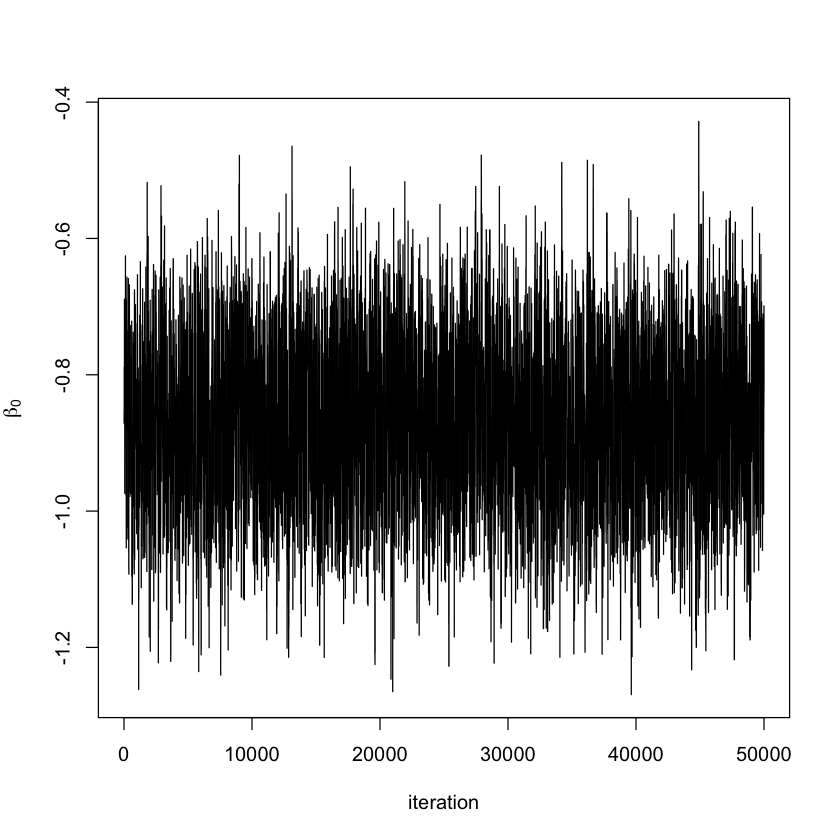

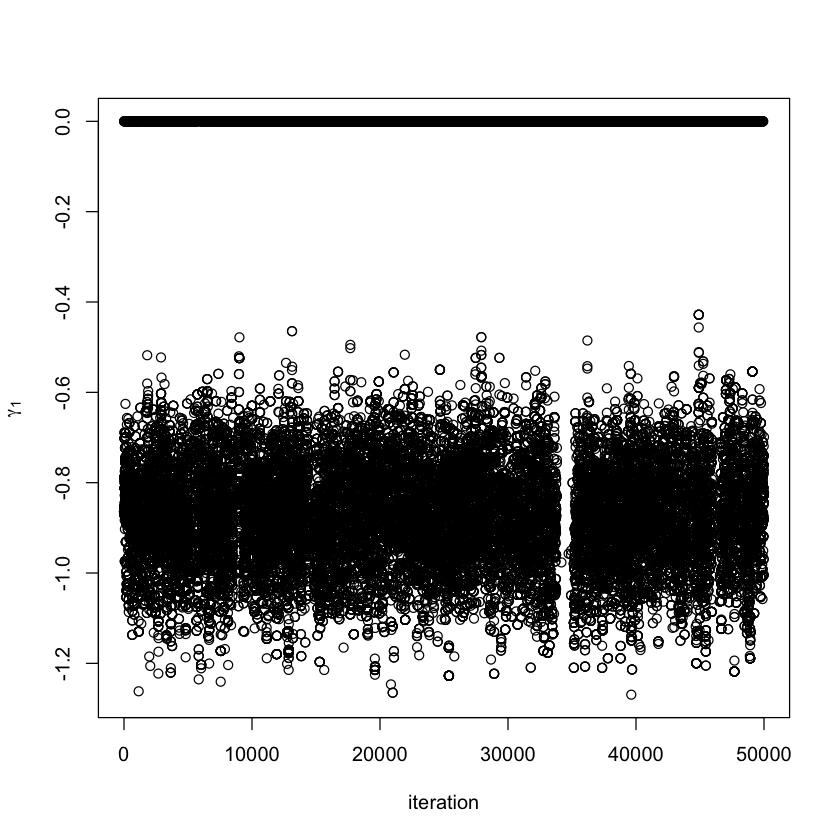

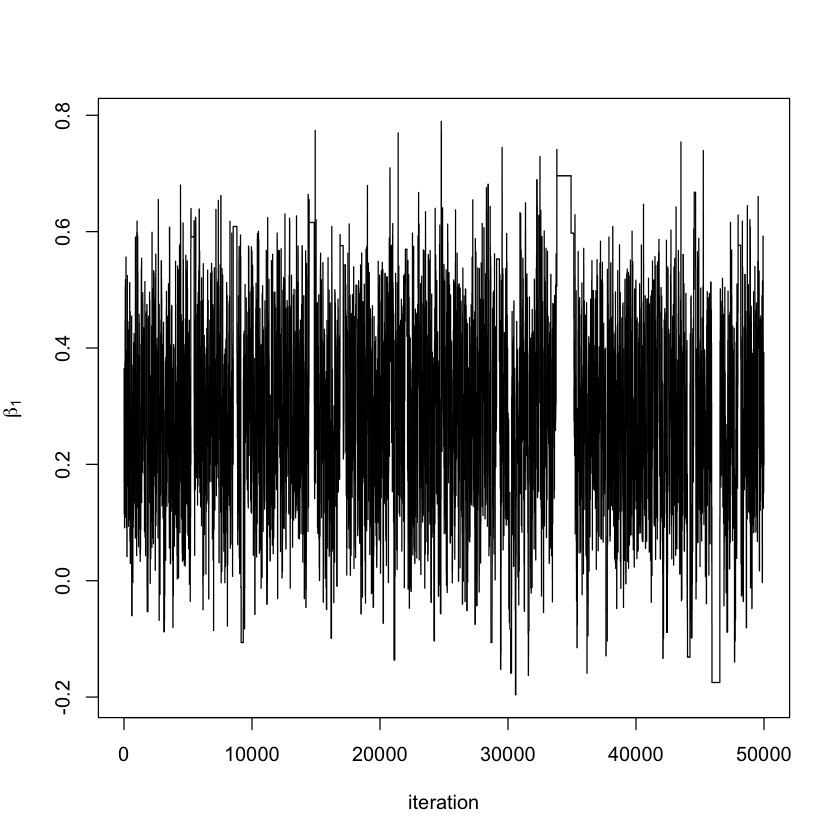

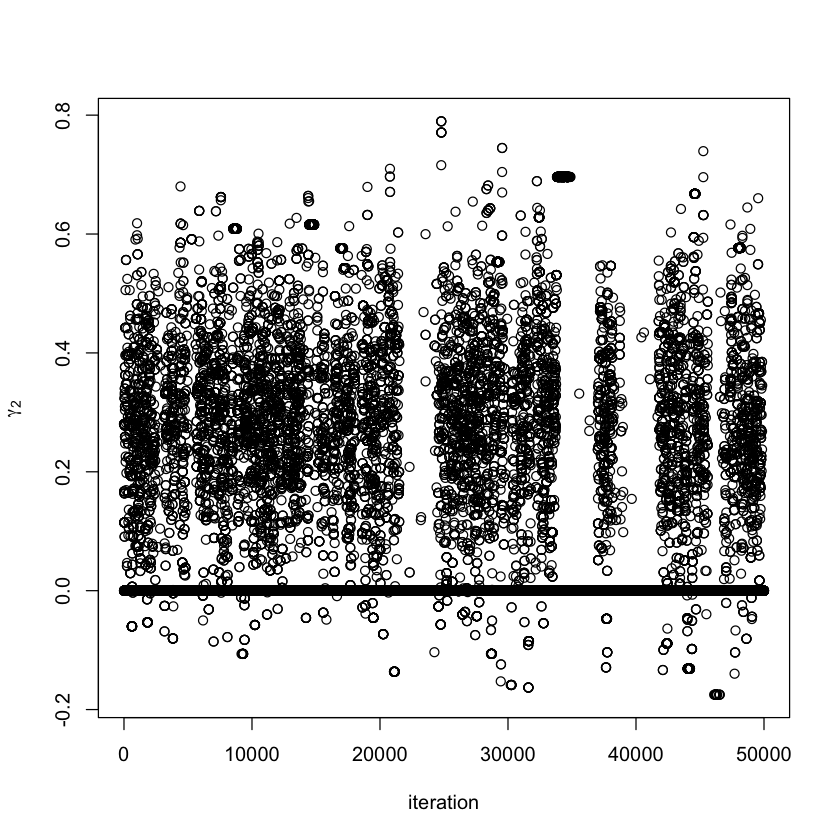

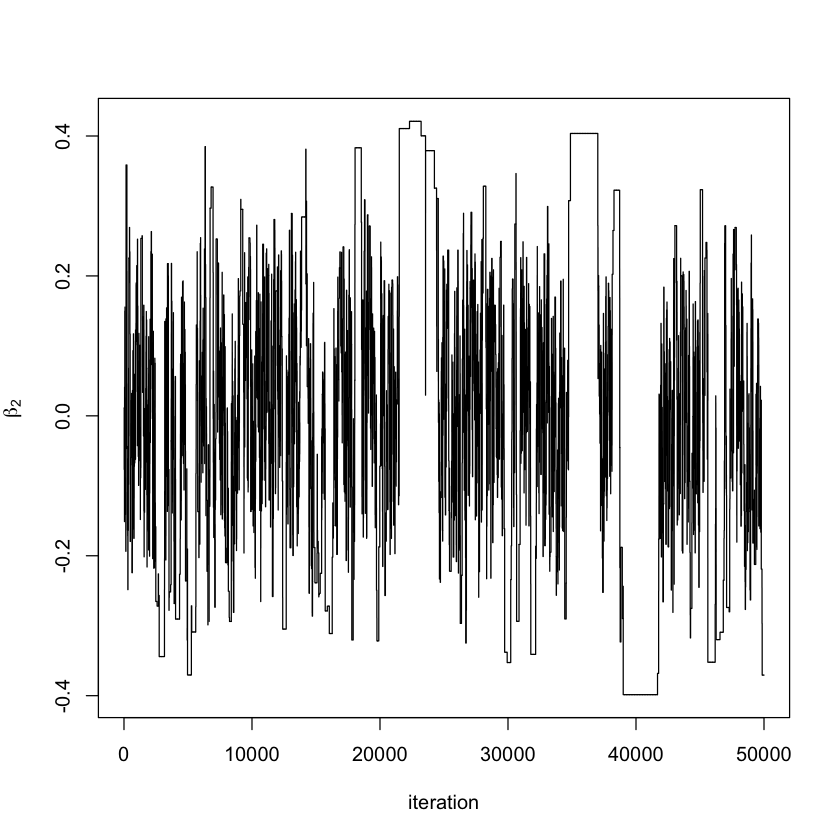

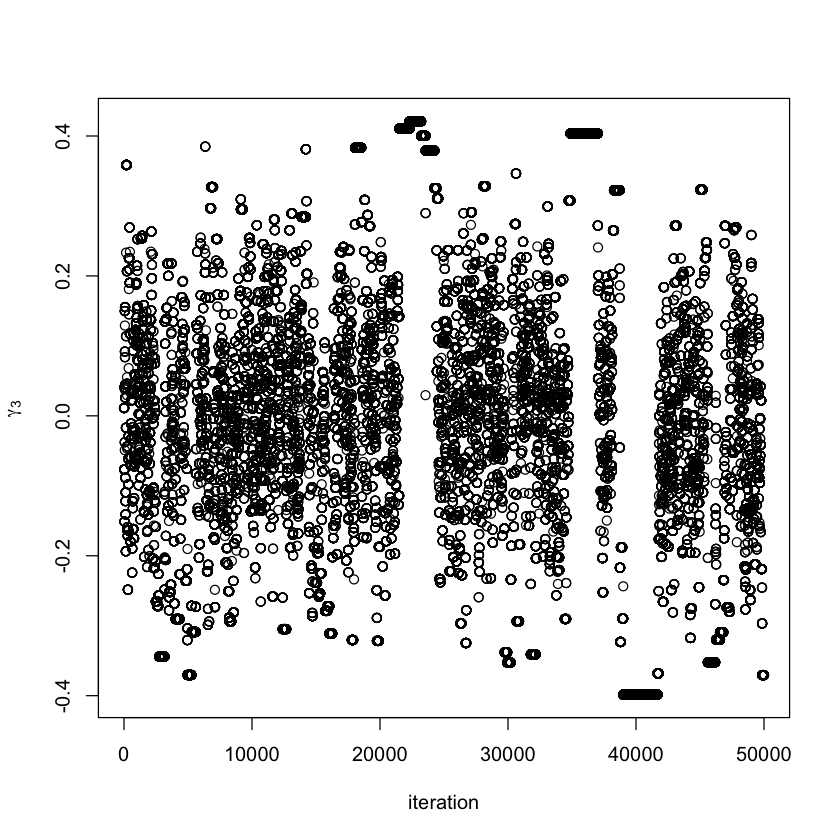

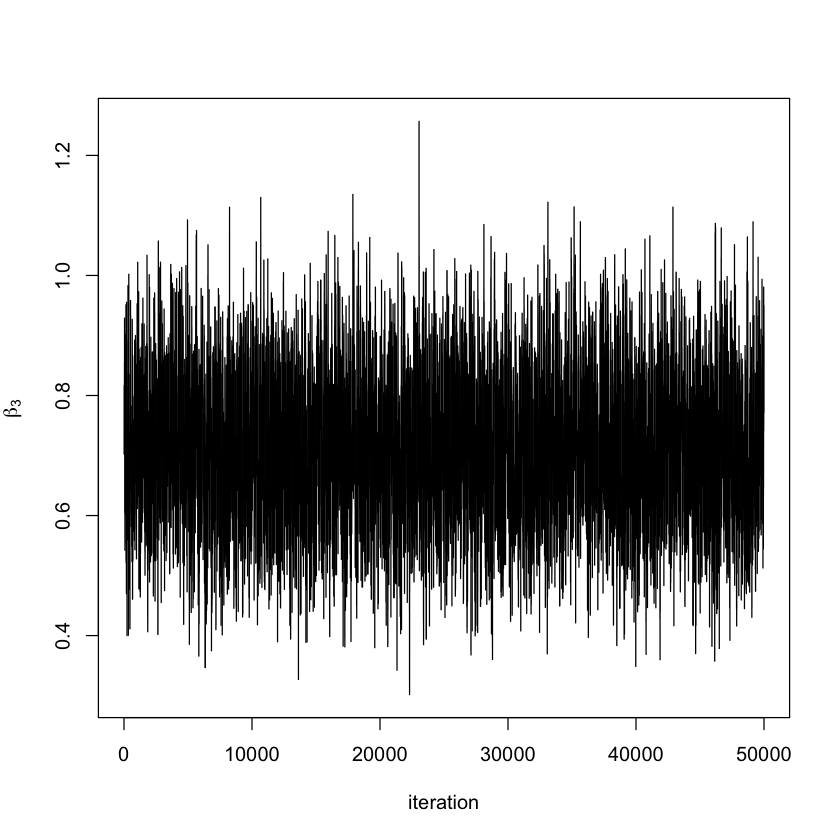

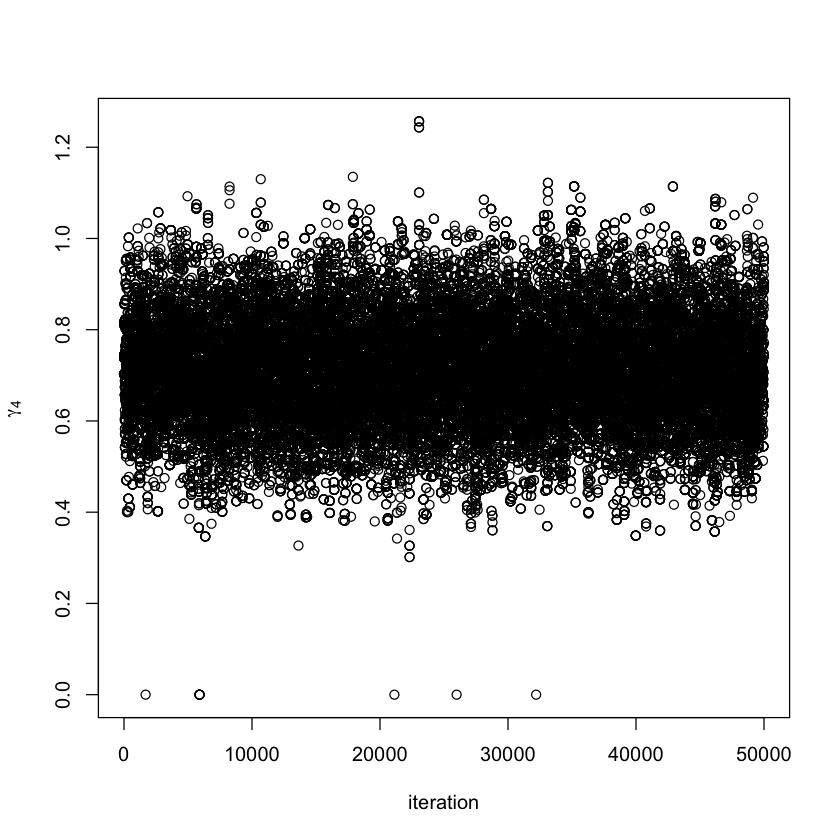

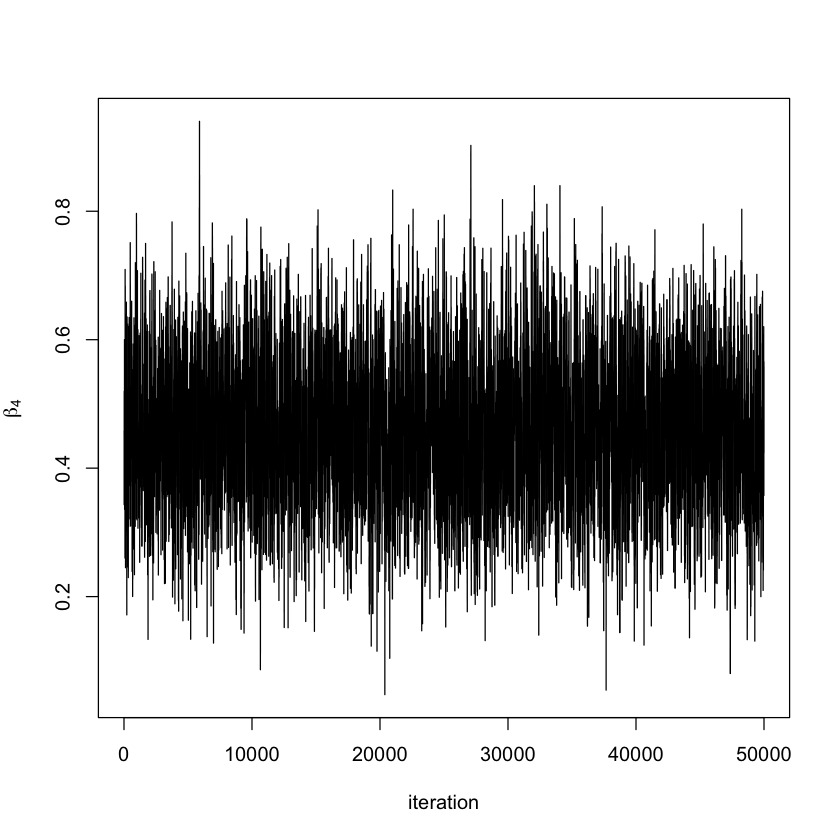

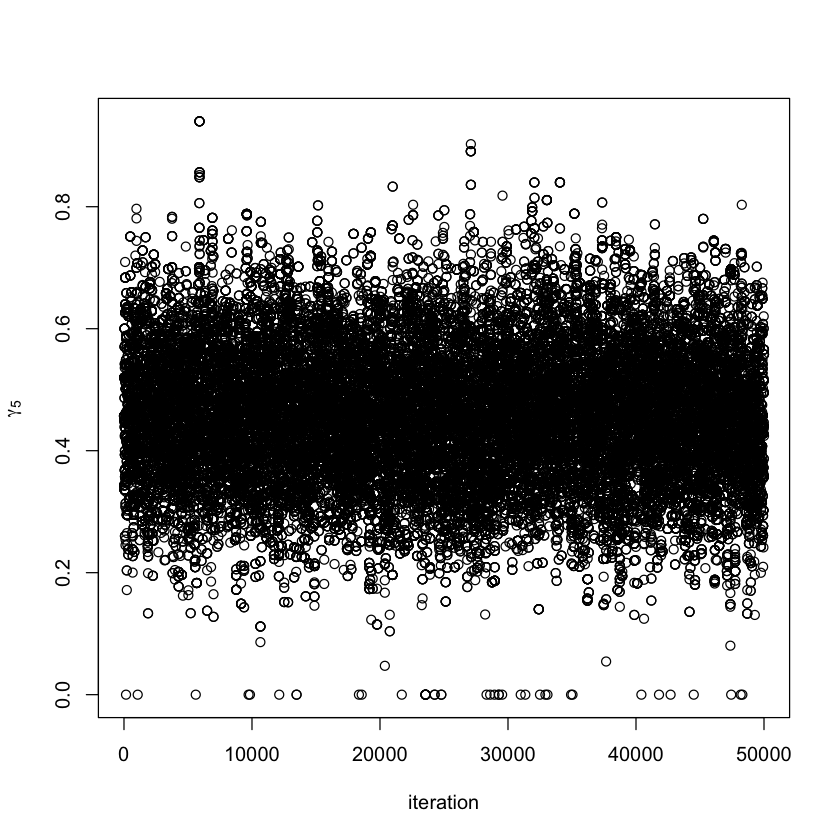

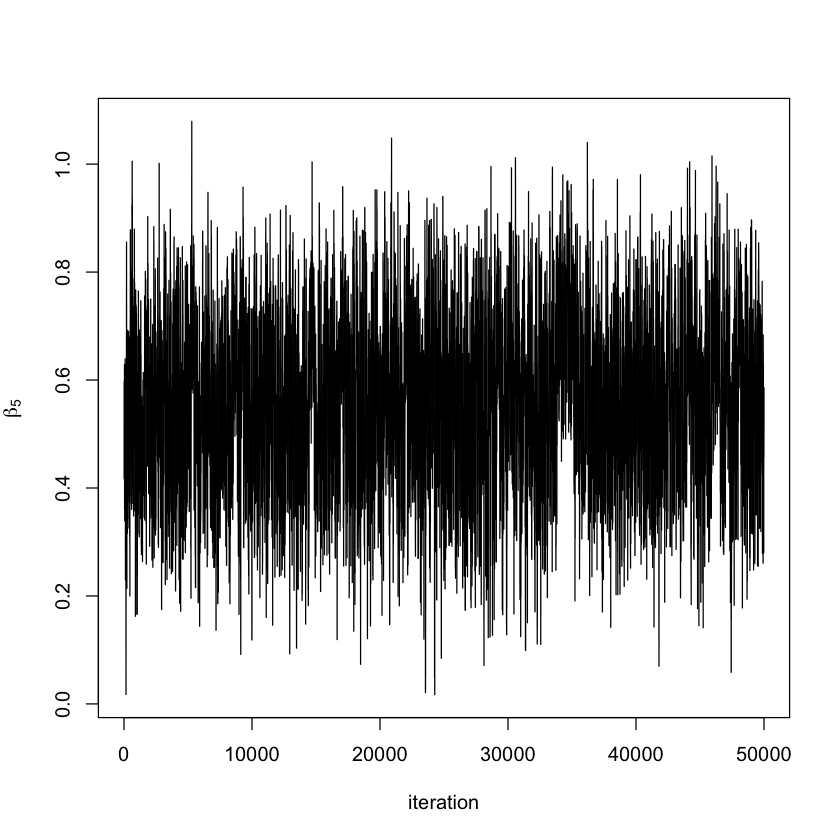

In [9]:
par(bg='white')
for(i in 1:6){
    plot(Beta[,i],type='l',ylab=bquote(beta[.(i-1)]),xlab='iteration')
    if(i!=6){
    plot(Gamma[,i]*Beta[,i],ylab=bquote(gamma[.(i)]),xlab='iteration')
    }
}

In [10]:
# Create a sample vector
sample_vector <- c('A', 'B', 'C', 'A', 'B')

# Convert the vector to a factor
factor_vector <- factor(sample_vector)

# Print the factor vector
print(factor_vector)


[1] A B C A B
Levels: A B C
